In [1]:
import scipy.io
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sc
numChannels = 96
noiseCodes = [0,255]
timeBase=np.arange(-.2,2.5,.01)
gratingOn = 0
gratingOff = 2

In [2]:
matIn=scipy.io.loadmat('arrayDATA.mat')

In [3]:
#matIn['DATA']

In [4]:
numTrials = len(matIn['DATA'])
allOris=[matIn['DATA'][_][0][1][0][0] for _ in range(numTrials)] #intermediate variable
ori = list(set(allOris))
numOri = len(ori)
trialIndices = defaultdict(list)

In [5]:
for tt in range(numTrials):
    for oo in ori:
        if allOris[tt] == oo:
            trialIndices[oo].append(tt)

In [6]:
numOris = len(ori)
spikeTimes=[[[[] for _ in range(numChannels)] for __ in range(numOris)] for ___ in range(numTrials)]
for orind,oo in enumerate(ori): # %8
    for tt in trialIndices[oo]:# %9
        for cc in range(numChannels): #%7
            spikeTimes[tt][orind][cc] = [spike[2] for spike in matIn['DATA'][tt][0][0]\
                                         if (spike[0]==cc) and (spike[1] not in noiseCodes)]

In [7]:
linearizedSpikeTimes = defaultdict(lambda: defaultdict(list))
for eachtrial in matIn["DATA"]: #2
    stimori = eachtrial[0][1][0][0]
    for eachspike in eachtrial[0][0]:
        if eachspike[1] not in [0,255]: # if the value is good
            trode = eachspike[0] #4
            spikeTimes = eachspike[2]
            linearizedSpikeTimes[trode][stimori].append(spikeTimes)

In [8]:
PSTHs = defaultdict(lambda: defaultdict(list))
for unitkey in linearizedSpikeTimes.keys():
    PSTHs[unitkey][0],bins = np.histogram(linearizedSpikeTimes[unitkey][0], bins=timeBase)
    PSTHs[unitkey][90],bins = np.histogram(linearizedSpikeTimes[unitkey][90], bins=timeBase)

In [9]:
for unitkey in PSTHs.keys(): #12
    fig=plt.figure(facecolor='w') #1
    for orind,oo in enumerate(ori):
        ax = fig.add_subplot(2,1,orind+1)
        ax.plot(timeBase[:-1],PSTHs[unitkey][oo],lw=3,color='b') #3
        ax.set_xlim([-.2,2.5]) #5
        ax.vlines(gratingOn,0,max(PSTHs[unitkey][oo]),color='k',linestyle='--') #4
        ax.vlines(gratingOff,0,max(PSTHs[unitkey][oo]),color='k',linestyle='--')
        ax.set_ylabel('spike count per bin') #6
        ax.set_xlabel('time in seconds') #6
        ax.set_title('Channel = '+str(int(unitkey))+' Orientation = '+str(oo)) #7
    plt.tight_layout() #9
    plt.show() #11

/Users/erikleenylen/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [10]:
livePSTHs = PSTHs #0
deadchannels = [21, 31, 34, 56, 68] #1
[livePSTHs.pop(dead, None) for dead in deadchannels ] #2
numChanLeft = len(livePSTHs) #3

In [11]:
rSC = np.zeros(shape=(len(livePSTHs),len(livePSTHs),len(ori)))  #1
for rowind,rowkey in enumerate(livePSTHs.keys()): #6
    for colind,colkey in enumerate(livePSTHs.keys()): #5
        for oind,oo in enumerate(ori): #4
            rSC[rowind,colind,oind],dummy =sc.pearsonr(livePSTHs[rowkey][oo], livePSTHs[colkey][oo]) #3
globalMean=np.mean(rSC) #7

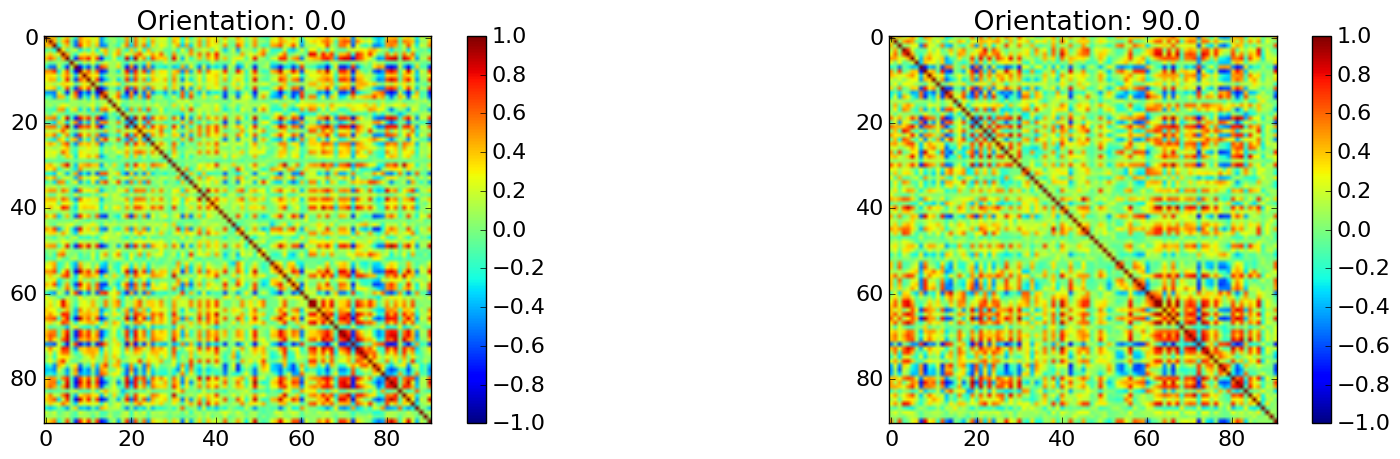

In [12]:
import matplotlib #0
%matplotlib inline
fig=plt.figure(figsize=(20,5)) #1
for orind,oo in enumerate(ori): #9
    ax=fig.add_subplot(1,2,orind+1) #2
    plt.imshow(rSC[:,:,orind],clim=(-1,1)) #3
    plt.colorbar() #6
    plt.title(' Orientation: '+str(oo)) #7
    matplotlib.rcParams.update({'font.size': 16}) #8


In [13]:
kernel = np.ones(5)
convS = np.convolve(PSTHs[unitkey][oo],kernel)
convT = np.convolve(PSTHs[unitkey][oo],kernel)

In [14]:
# add in extensive code surgery here